# Part 1: Image Compression with the Singular Value Decomposition

## Favorite Image to Greyscale

In [1]:
from matplotlib import pyplot as plt
import numpy as np

import PIL
import urllib

def read_image(url):
    return np.array(PIL.Image.open(urllib.request.urlopen(url)))

In [2]:
url = "https://www.comingsoon.net/wp-content/uploads/sites/3/2023/01/phineas-and-ferb.png?w=1024"

img = read_image(url)

[Text(0.5, 1.0, 'greyscale')]

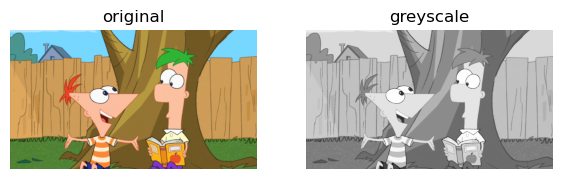

In [3]:
fig, axarr = plt.subplots(1, 2, figsize = (7, 3))

def to_greyscale(im):
    return 1 - np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])

grey_img = to_greyscale(img)

axarr[0].imshow(img)
axarr[0].axis("off")
axarr[0].set(title = "original")

axarr[1].imshow(grey_img, cmap = "Greys")
axarr[1].axis("off")
axarr[1].set(title = "greyscale")

k=5, i=0, j=0
k=10, i=0, j=1
k=15, i=0, j=2
k=20, i=1, j=0
k=25, i=1, j=1
k=30, i=1, j=2
k=35, i=2, j=0
k=40, i=2, j=1
k=45, i=2, j=2


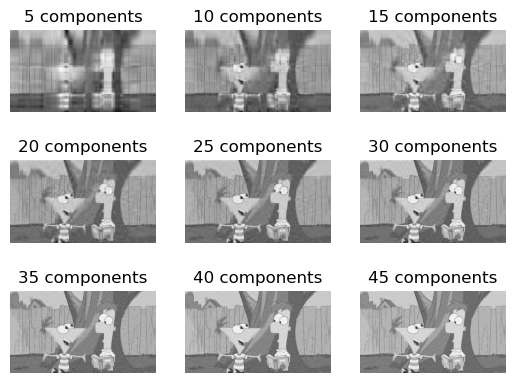

In [4]:
from unsupervised_learning import svd_reconstruct, svd_experiment
svd_experiment(to_greyscale(img))